# Questions
This analysis evaluates factors that impact inflation, the rate of price increases within an economy. Two factors are examined over time:
 - Gross Domestic Product per Capita Growth
 - Population Growth Rate
 
GDP per Capita is used as a measure of wealth in an economy, normalized for population. Population growth is used to represent the growth of human capital within an economy. It is hypothesized that both factors have a positive correlation with inflation. 

Additionally, this analysis will examine whether countries with fast-growing populations also become wealthier faster (positive correlation). It is hypothesized that quickly growing populations will also support faster growing wealth per person.

# Data Sources
Because Inflation is an annual rate, annual rates are also used for GDP/Capita and Population Growth. All data files are from Gapminder.Org without alteration, with the data originally sourced by the World Bank:
 - [Inflation Rates](http://docs.google.com/spreadsheet/pub?key=0AkBd6lyS3EmpdGJoOUJXalk3STFYUG85MkxlbnQxMmc&output=xlsx)
 - [GDP/Capita Growth](http://docs.google.com/spreadsheet/pub?key=0AkBd6lyS3EmpdEdDWHhBcFpjMUo4MGE2X2Q4WXFQRGc&output=xlsx)
 - [Population Growth](http://docs.google.com/spreadsheet/pub?key=0AkBd6lyS3EmpdFY5Z0QzTzRRbzJ1VXdqdGVyNE0tcFE&output=xlsx)

# Limitations
Inflation is a complex process. The definition of inflation, nonetheless it causes and measurements, are still debated by the economists in central banks charged with its management. Accordingly, any relationships examined are unlikely to be comprehensive, and may interact with factors outside the scope of this analysis. Traditional theories emphasize out-of-scope factors as primary drivers of inflation, such as money supply, unemployment and labor force participation. These factors are not examined, as the data cannot be sourced within the approved scope of this Udacity project.

The examination will be limited to the 1961 to 2010 period - where data is available for all variables. However, World Bank datasets include all countries that existed at any point during the sampled timeframe. Data is not available for all these countries due to the creation and dissolution of some states during the examination period. Likewise, additional countries are missing data due to difficulties in measuring and reporting data to the World Bank.

# Nomenclature

For ease and consistency in commentary, the below terms will be used to refer to the indicators under examination:
 - Inflation Rate as 'Inflation'
 - Gross Domestic Product per Capita Growth as 'GDP/Capita'
 - Population Growth Rate as 'Population Growth'

# Data Loading

In [1]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns
plt.style.use('seaborn-deep')

Each .csv is read into a Pandas dataframe. The index is specified at 0, so each country's name will be used as the inital index. Encoding is set to 'latin1' in order to read the characters in each .csv.

Because the data is oriented 'wide', with each column headed by a year, further restructuring is required prior to merging. 

Each dataframe is transposed, which reorients the data and indexes by the annual timeseries. The dataframes are then unstacked to reorient from a 'wide' to 'long' structure, and the index is reset to facilitate merging all three dataframes.

In [2]:
gdp = pd.read_csv('gdp_growth_capita.csv',index_col=0,parse_dates=True,encoding='latin1').transpose().unstack().reset_index()
inflation = pd.read_csv('inflation_rates.csv',index_col=0,parse_dates=True,encoding='latin1').transpose().unstack().reset_index()
population = pd.read_csv('population_growth.csv',index_col=0,parse_dates=True,encoding='latin1').transpose().unstack().reset_index()

# Standardizing Dataframes
The dataframe columns will need to be renamed, as the indexes and column headers native to each .csv are now values in the dataframes. Thankfully, all the dataframes follow the same structure, so a loop can be used referencing the location of each column.

Additionally, a name is set for the variables holding each dataframe, so that it can be used by the loop to rename the column containing that indicator's value.

Each dataframe is then looped over, renaming the columns to 'Country', 'Year', and the name of each indicator. Additionally, the 'Year' column is converted to a datetime type, so that Pandas will treat the year as a date rather than string. Each indicator column is already read as a float.

In [3]:
#define names for each df for use in loop, to name column containing values within each df
inflation.name = 'Inflation'
gdp.name = 'GDPCapita'
population.name = 'PopGrowth'

dfs = [inflation, gdp, population] #list of dfs to loop over
for df in dfs:
    dfname = str(df.name) #store df name as a string
    df.rename(columns={df.columns[0]: 'Country', df.columns[1]: 'Year', df.columns[2]: '{}'.format(dfname)},inplace=True) #rename columns according to location, use the assigned name for column containing each indicator's values
    df['Year'] = pd.to_datetime(df['Year']) #convert 'Year' column to datetime type

# Merging Data

With each dataframe converted into a 'long' format with standardized column names for 'Country' and 'Year', it is easy to merge all three into a single dataframe with a loop.

First, a function is defined with a new variable holding an empty dataframe. The loop checks to see if the dataframe is empty, which it will be on the first iteration, then populates the current dataframe into the variable. On the next iteration the new dataframe will not be empty, so it looks to merge it with the current dataframe on the 'Country' and 'Year' columns. 

The final dataframe is returned by the function. All rows containing 2011 in the 'Year' column are filtered out, as GDP/Capita data is not available for that year.

This function is then assigned to a new variable for further analysis.

In [4]:
def merge_dfs():
    dfs = [inflation, gdp, population] #list of dfs to loop over
    newdf = pd.DataFrame() #create empty dataframe object
    for df in dfs:
        if newdf.empty: #dataframe will be empty on first iteration
            newdf = df #populate empty dataframe with current dataframe in first iteration
        else:
            newdf = pd.merge(newdf,df,how='left',left_on=['Country','Year'],right_on=['Country','Year']) #merge dataframes by 'Country' and 'Year' in sub sequent iterations
    return newdf[newdf.Year != '2011-01-01'] #remove data from 2011 as it's not available in all datasets

In [5]:
merged_df = merge_dfs() #create new variable from merge function

In [6]:
merged_df.isnull().sum() #sum remaining NaNs

Country         0
Year            0
Inflation    5784
GDPCapita    6078
PopGrowth    2911
dtype: int64

# NaN and Outlier Handling
After merging the dataframes, there will be missing / NaN ('not a number') values for certain countries and time periods across the indicators. Because the analysis is looking to examine the relationship of GDP/Capita and Population Growth to Inflation, any rows that do not contain Inflation data can be excluded from that analysis. 

Likewise, for the analysis of above-mean GDP/Capita and Population Growth, any row not containing both values can be excluded, as there is insufficient data for analysis. Remaining NaNs are then summed in each indicator for further handling.

In [7]:
merge_contains_inf = merged_df[pd.notnull(merged_df['Inflation'])] #retains only rows where 'Inflation' is not NaN
merge_contains_gdppop = merged_df.drop(['Inflation'], axis=1).dropna(how='any') #drops 'Inflation' and any row missing ether GDP/Capita or Popualation values

In [8]:
merge_contains_inf.isnull().sum() #sum remaining NaNs

Country        0
Year           0
Inflation      0
GDPCapita    371
PopGrowth      4
dtype: int64

In [9]:
merge_contains_gdppop.isnull().sum() #sum remaining NaNs

Country      0
Year         0
GDPCapita    0
PopGrowth    0
dtype: int64

Before handling the remaining NaNs, extreme inflation values will be filtered out of the analysis. Under the assumption that wealth and population growth are long-term phenomena, excessive annual inflation readings are likely the result of shorter-term shocks outside of any persistent, secular relationships. 

To identify and remove the outliers, boundaries are set at 1.5 times the interquartile range. Values outside the boundaries are dropped.

In [10]:
inf_IQR = merge_contains_inf['Inflation'].quantile(.75) - merge_contains_inf['Inflation'].quantile(.25) #uses quantile methods to find upper and lower quantile, subtracts for IQR
inf_max_bound = merge_contains_inf['Inflation'].quantile(.75) + (1.5 * inf_IQR) #defines upper bound for outliers
inf_min_bound = merge_contains_inf['Inflation'].quantile(.25) - (1.5 * inf_IQR) #defines lower bound for outliers

merge_contains_inf = merge_contains_inf[(merge_contains_inf['Inflation'] > inf_min_bound) & (merge_contains_inf['Inflation'] < inf_max_bound)] #filters dataframe for all values above lower band and below upper band

Remainings NaNs are summarized again to health-check the cleanup. Further sanitization will be required for the inflation analysis. 

Separate variables will be created for inflation's relationships with GDP/capita and population growth. This will retain the ability to correlate both relationships, without needlessly dropping data from one indicator because of its abesence in the other. 

This will improve the accuracy of any conclusions in two-dimensional analysis, but would limit multi-dimensional analysis using the new variables.

In [11]:
merge_contains_inf.isnull().sum() #sum remaining NaNs

Country        0
Year           0
Inflation      0
GDPCapita    341
PopGrowth      4
dtype: int64

In [12]:
merge_inf_gdp = merge_contains_inf.drop('PopGrowth',axis=1).dropna() #defines separate variable containing only Inflation and GDP/Capita data, drops missing GDP values
merge_inf_pop = merge_contains_inf.drop('GDPCapita',axis=1).dropna() #defines separate variable containing only Inflation and Population Growth data, drops missing Population values

In [13]:
merge_inf_gdp.isnull().sum() #sum remaining NaNs

Country      0
Year         0
Inflation    0
GDPCapita    0
dtype: int64

In [14]:
merge_inf_pop.isnull().sum() #sum remaining NaNs

Country      0
Year         0
Inflation    0
PopGrowth    0
dtype: int64

# Plotting Macro Averages
For a cursory macro analysis, the data is averaged on an annual basis for each indicator. These averages are then plotted over time to show any directional bias or trends in each indicator.

Because the '.mean()' method defaults to skip NaN values, the refined variables defined above are not required for these plots. This allows for simplified code and variable use while resulting in the same outputs.

In [15]:
global_avgs = merge_contains_inf.groupby('Year').mean() #groups the merged inflation data by year and averages GDP/capita and population growth

In [16]:
#colors defined here as variables for consistent plotting below and ease of change
inf_color = '#ff796c'
gdp_color = '#8eab12'
pop_color = '#5a7d9a'

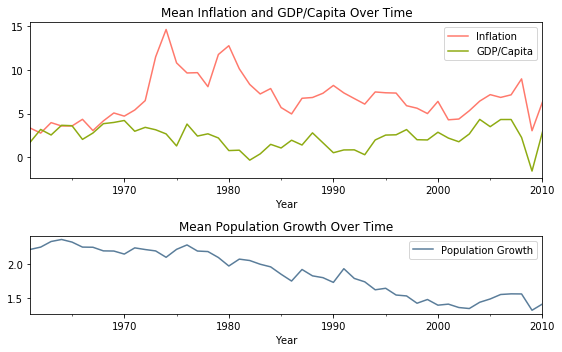

In [17]:
fig = plt.figure(figsize=[8,5]) #creates a figure, sets size at 8x5
gs = gridspec.GridSpec(2, 1, height_ratios=[2,1]) #creates a 2x1 grid for subplotting, fixes height ratio at 2:1

ax1 = plt.subplot(gs[0]) #assigns ax1 to index 0 in the grid
ax2 = plt.subplot(gs[1]) #assigns ax2 to index 1 in the grid
ax1.set_title('Mean Inflation and GDP/Capita Over Time') #sets ax1 title
ax2.set_title('Mean Population Growth Over Time') #sets ax2 title

global_avgs['Inflation'].plot(ax=ax1,color=inf_color,label='Inflation') #plots mean Inflation series
global_avgs['GDPCapita'].plot(ax=ax1,color=gdp_color,label='GDP/Capita') #plots mean GDP/Capita series
global_avgs['PopGrowth'].plot(ax=ax2,color=pop_color,label='Population Growth') #plots mean Population Growth series

ax1.legend() #prints ax1 legend
ax2.legend() #prints ax2 legend

plt.tight_layout() #sets a tight layout between the subplots
plt.show() #shows plot in notebook

Population Growth is given its own subplot due to the differences in scale and volatility compared to Inflation and GDP/Capita growth, which would make the changes difficult to read on a single plot.

At a glance, it would appear that global Inflation tends to run higher than both GDP/Capita and Population Growth. While Population Growth has seen a steady downtrend during the examination period, inflation and GDP/Capita do not exhibit strong trends. While Inflation spiked in the mid-1970s and remained high for a decade, it sub sequentially stabilized. All three indicators experienced a negative shock during the financial crisis of 2008.

However, it is important to note that these timeseries represent the mean of national rates, rather than a true global rate for each indicator. When taking the mean of all rates, large countries will share equal weight with small countries - this will overstate the contributions of small countries and understating large countries in the global mean. Accurate calculation of global Inflation, GDP/Capita or Population Growth would require calculation of year-on-year percentage change from a summation of all consumer prices, GDP, and population values.

Likewise, because NaN values exist (but are ignored) for GDP/Capita and Population Growth throughout the timeseries, those series are more sensitive to their component values than Inflation at some points in time - but these instances cannot be discerned by this visualization. 

Accordingly, valid comparisons with the in-scope data can only be drawn for the indicators' readings within each country where full data is available for each year. Recognizing this shortcoming in the source data, these limitations are extended while producing a timeseries of correlations between the indicators.

# Plotting Macro Correlations
To address the primary question of the analysis, the '.corr()' method can be used on each refined dataframe to generate correlation coefficients for all indicator data, across all countries and years in the examination. 

The outputs suggests that, contrary to the intial hypothesis, both GDP/Capita and Population Growth are very weakly correlated with inflation - and the p values indicate these are significant results beyond a .01 threshold. Inflation and Population Growth have a slight positive correlation, whereas Inflation has a slight negative correlation with GDP/Capita. Accordingly, the hypotheses posed by this analysis can be rejected.

However, this analysis will be be further refined to look at the correlations over time, and both within and between individual countries.

In [18]:
#below prints the name of the variables being correlated, and uses scipy to return the correlation coefficient and p-value for significance testing

print('R- and P-Values for Inflation and GDP/Capita : ',pearsonr(merge_inf_gdp['Inflation'],merge_inf_gdp['GDPCapita']))
print('R- and P-Values for Inflation and Population Growth : ',pearsonr(merge_inf_pop['Inflation'],merge_inf_pop['PopGrowth']))
print('R- and P-Values for Population Growth and GDP/Capita : ',pearsonr(merge_contains_gdppop['PopGrowth'],merge_contains_gdppop['GDPCapita']))

R- and P-Values for Inflation and GDP/Capita :  (-0.065396328520003544, 1.0473265346844973e-07)
R- and P-Values for Inflation and Population Growth :  (0.047668156426174502, 7.1172548622513903e-05)
R- and P-Values for Population Growth and GDP/Capita :  (-0.076194920751826378, 4.9551100175945466e-11)


To examine how these correlations change over the examination period, timeseries will be created calculating inflation's correlation to GDP/Capita and population growth, across all countries for which the respective indicator data is available. For additional context, a timeseries will be constructed from the correlation between GDP/Capita and population growth.

To accomplish this, new variables are created using the sanitized dataframes for each indicator. 'Year' and 'Inflation' data is selected, grouped by 'Year', to be correlated with the corresponding indicator. This outputs a single column of correlation coefficients in a column to be renamed. This is preferable to the '.corr' method, which will produce a matrix - in which half the data is correlated to itself for a perfect '1' correlation, and creates needless difficulty for plotting on a timeseries.

In [19]:
ts_inf_gdp_corr = (merge_inf_gdp[['Year','Inflation']] #defines new variable for correlation series between inflation and gdp/capita, selects Year and Inflation data
           .groupby('Year') #groups data by year
           .corrwith(merge_inf_gdp.GDPCapita) #correlates inflation with gdp data
           .rename(columns={'Inflation' : 'Inf_GDPCap_Corr'})) #renames columns for readability

ts_inf_pop_corr = (merge_inf_pop[['Year','Inflation']] #defines new variable for correlation series between inflation and population, selects Year and Inflation data
           .groupby('Year') #groups data by year
           .corrwith(merge_inf_pop.PopGrowth) #correlates inflation with population data
           .rename(columns={'Inflation' : 'Inf_Pop_Corr'})) #renames columns for readability

ts_pop_gdp_corr = (merge_contains_gdppop[['Year','PopGrowth']] #defines new variable for correlation series between population and gdp/capita, selects Year and Inflation data
            .groupby('Year') #groups data by year
            .corrwith(merge_contains_gdppop.GDPCapita) #correlates population with gdp/capita data
            .rename(columns={'PopGrowth' : 'Pop_GDP_Corr'})) #renames columns for readability

Once the correlation timeseries are created, they can be plotted to show the relationships between indicators over the examination period. 3 year moving averages are plotted for each correlation timeseries to smooth the data and improve readability. The selection of a 3 year average is arbitrary, as no conclusions will be drawn from it.

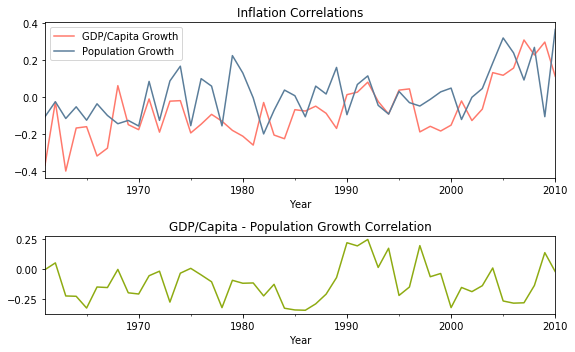

In [20]:
fig = plt.figure(figsize=[8,5]) #defines new figure, size fixed at 8x5
gs = gridspec.GridSpec(2, 1, height_ratios=[2,1]) #creates a 2x1 grid for subplotting, fixes height ratio at 2:1

ax1 = plt.subplot(gs[0]) #assigns ax1 to index 0 of the grid
ax2 = plt.subplot(gs[1]) #assigns ax2 to index 1 of the grid

ax1.set_title('Inflation Correlations') #defines ax1 title
ax2.set_title('GDP/Capita - Population Growth Correlation') #defines ax2 title

#Moving averages commented-out below as Udacity feedback suggested they reduced readability

ts_inf_gdp_corr['Inf_GDPCap_Corr'].plot(ax=ax1,color=inf_color,label='GDP/Capita Growth') #plot inflation and gdp/capita correlation
#ts_inf_gdp_corr['Inf_GDPCap_Corr'].rolling(3).mean().plot(ax=ax1,color=inf_color,label='_nolegend_')

ts_inf_pop_corr['Inf_Pop_Corr'].plot(ax=ax1,color=pop_color,label='Population Growth') #plot inflation and population growth correlation
#ts_inf_pop_corr['Inf_Pop_Corr'].rolling(3).mean().plot(ax=ax1,color=pop_color,label='_nolegend_')

ts_pop_gdp_corr['Pop_GDP_Corr'].plot(ax=ax2,color=gdp_color,) #plot population and gdp/capita correlation
#ts_pop_gdp_corr['Pop_GDP_Corr'].rolling(3).mean().plot(ax=ax2,color=gdp_color)



ax1.legend(loc=2) #print ax1 legend in top left
plt.tight_layout() #set tight layout to subplots
plt.show() #show plots in notebook

Both GDP/Capita and Population Growth exhibit weak correlation to Inflation over the examination period, with readings for both bounded between -0.40 and .36. However, the plot demonstrates that both have demonstrated relatively stronger positive correlation in recent history, though this effect is still weak and inconsistent. GDP/Capita exhibits a persistent, weak negative correlation to Inflation from 1961 until the early 2000s. The correlation between Population Growth and Inflation oscillates between weakly positive and negative readings until, like GDP/Capita growth's correlation, begins a weak positive correlation in the early 2000s.

Likewise, GDP/Capita and Population Growth exhibit weaker correlation to each other, than either indicator's correlation to Inflation (bounded between -.34 and .24). Population growth consistently maintained a weakly negative correlation with GDP/Capita growth from 1960 until the late 1980s - after which the two indicators oscillated between weakly positive and negative readings.

Although all indicators show weak correlation across the timeseries, it is worth noting that the relationships are not stable and do experience streaks of positive and negative correlation. Likewise, the minimum and maximum readings experienced year-to-year suggest temporary relationships that can be many times stronger than the relationships as-measured over the entire examination period.

# Intra-Country Comparisons

While the relationships between indicators appear weak at a global level throughout the examination period, individual countries may exhibit stronger correlations. This can be accomplished with an approach similar to that used in the macro analyses, but with grouping by 'Country' instead of 'Year'.

First, scatter plots will be used to visualize the relationships between indicators throughout the entire examination period. This will require grouping our indicator data by country, and reducing the time dimension through a summary statistic. Accordingly, means for each country will be calculated and plotted.

In [21]:
country_avgs = merge_contains_inf.groupby('Country').mean() #create new variable taking inflation mean for each country

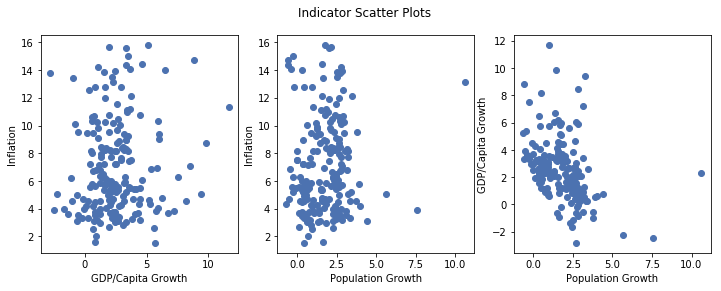

In [22]:
fig = plt.figure(figsize=[12,4]) #defines new figure, size fixed at 12x4
gs = gridspec.GridSpec(1, 3) #creates 1x3 grid for subplotting

ax1 = plt.subplot(gs[0]) #assigns ax1 to index 0 of grid
ax2 = plt.subplot(gs[1]) #assigns ax2 to index 1 of grid
ax3 = plt.subplot(gs[2]) #assigns ax3 to index 2 of grid

ax1.set_xlabel('GDP/Capita Growth') #defines ax1 x label
ax1.set_ylabel('Inflation') #defines ax1 y label

ax2.set_xlabel('Population Growth') #defines ax2 x label
ax2.set_ylabel('Inflation') #defines ax2 y label

ax3.set_xlabel('Population Growth') #defines ax3 x label
ax3.set_ylabel('GDP/Capita Growth') #defines ax3 y label


ax1.scatter(country_avgs['GDPCapita'],country_avgs['Inflation']) #plots scatter of country inflation and gdp/capita
ax2.scatter(country_avgs['PopGrowth'],country_avgs['Inflation']) #plots scatter of country inflation and population growth
ax3.scatter(country_avgs['PopGrowth'],country_avgs['GDPCapita']) #plots scatter of country population growth and gdp/capita

fig.suptitle('Indicator Scatter Plots') #sets title for figure across all subplots

#plt.tight_layout() 

plt.show() #shows plot in notebook

Upon visual examination, the scatter plots look centrally grouped with no discernable trend. To enhance this analysis, we can calculate correlation coefficients for each indicator within each country, across the examination timeseries. This is similar to the approach taken on the global correlation timeseries, but once again, the 'Year' grouping will be replaced by 'Country'.

In [23]:
ct_inf_gdp_corr = (merge_inf_gdp[['Country','Inflation']] #defines new variable for correlation series between inflation and gdp/capita, selects Year and Inflation data
           .groupby('Country') #groups data by country
           .corrwith(merge_inf_gdp.GDPCapita) #correlates inflation with gdp/capita data
           .rename(columns={'Inflation' : 'Inf_GDPCap_Corr'})) #renames columns for readability

ct_inf_pop_corr = (merge_inf_pop[['Country','Inflation']] #defines new variable for correlation series between inflation and population growth, selects Year and Inflation data
           .groupby('Country') #groups data by country
           .corrwith(merge_inf_pop.PopGrowth) #correlates inflation with population growth data
           .rename(columns={'Inflation' : 'Inf_Pop_Corr'})) #renames columns for readability

ct_pop_gdp_corr = (merge_contains_gdppop[['Country','PopGrowth']] #defines new variable for correlation series between population growth and gdp/capita, selects Year and Inflation data
            .groupby('Country') #groups data by country
            .corrwith(merge_contains_gdppop.GDPCapita) #correlates inflation with gdp/capita data
            .rename(columns={'PopGrowth' : 'Pop_GDP_Corr'})) #renames columns for readability

C:\Users\Schonig LLC\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2487: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


While these function run without error and produce the series of correlations, runtime warnings are issued as some countries do not have enough years of data for confidence in the outputs. 

Historgrams will be plotted for the outputs to visualize the distribution of correlations, and a function will be defined to count the number of countries within each bin. Bins of '0.2' will be used evenly bucket the -1 to 1 range, with enough detail to show the distributions shape. 

As the global correlations in each indicator were weak year-to-year, it is expected that a majority of countries exhibit weak correlations throughout the entire examination period.

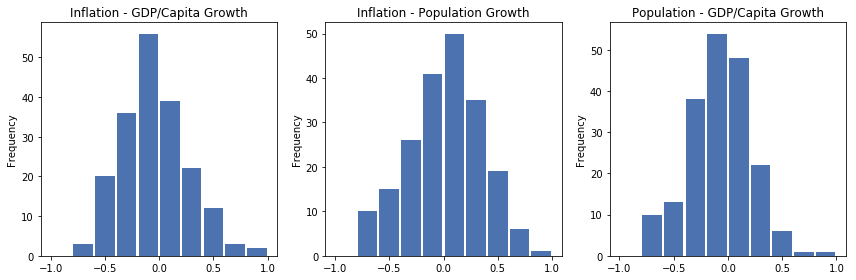

In [24]:
fig = plt.figure(figsize=[12,4]) #defines new figure, size fixed at 12x4
gs = gridspec.GridSpec(1, 3) #creates 1x3 grid for subplotting

ax1 = plt.subplot(gs[0]) #assigns ax1 to index 0 of the grid
ax2 = plt.subplot(gs[1]) #assigns ax2 to index 1 of the grid
ax3 = plt.subplot(gs[2]) #assigns ax3 to index 2 of the grid

ax1.set_title('Inflation - GDP/Capita Growth') #sets ax1 title
ax2.set_title('Inflation - Population Growth') #sets ax2 title
ax3.set_title('Population - GDP/Capita Growth') #sets ax3 title

bins = [-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1] #defines list for bin sizes

ct_inf_gdp_corr['Inf_GDPCap_Corr'].plot(kind='hist', bins=bins, rwidth=0.9,ax=ax1) #plots histogram of inflation and gdp/capita correlations
ct_inf_pop_corr['Inf_Pop_Corr'].plot(kind='hist', bins = bins, rwidth=0.9,ax=ax2) #plots histogram of inflation and population growth correlations
ct_pop_gdp_corr['Pop_GDP_Corr'].plot(kind='hist', bins = bins, rwidth=0.9,ax=ax3) #plots histogram of population growth and gdp/capita correlations


plt.tight_layout() #sets tight layout for subplots

plt.show() #shows plots in notebook

As expected, the distribution of correlations within individual countries were mostly weak throughout the examination period, with roughly half the countries bounded between correlations of -0.2 and 0.2. Likewise, negative correlation between Inflation and GDP/Capita, as well as between Population Growth and GDP/Capita, can be seen as the bulk of the data resides to the left of the '0' middle point.

However, some indicators did exhibit strong correlations within individual countries throughout the examination period. To identify these, the dataframes holding the indicator correlation coefficients can be merged and filtered for any strongly positive or negative readings (above 0.8 or below -0.8, respectively).

In [30]:
def merge_corrs():
    dfs = [ct_inf_gdp_corr, ct_inf_pop_corr, ct_pop_gdp_corr] #list of dfs to loop over
    newdf = pd.DataFrame() #creates new empty dataframe
    for df in dfs:
        if newdf.empty: #new dataframe will be empty on first iteration
            newdf = df #populate empty dataframe with current dataframe on first iteration
        else:
            newdf = pd.merge(newdf,df,how='left',left_index=True,right_index=True)  #merge sub sequent dataframes into new dataframe based on indexes
    return newdf #return the new dataframe

In [26]:
corrs_df = merge_corrs() #creates new variable to hold the merged dataframes
print(corrs_df[((corrs_df > 0.8).any(1))]) #prints any rows where values are above 0.8
print(corrs_df[((corrs_df < -0.8).any(1))]) #prints any rows where values are below -0.8

                 Inf_GDPCap_Corr  Inf_Pop_Corr  Pop_GDP_Corr
Country                                                     
Belarus                 0.816033     -0.061220     -0.593599
Brazil                  0.691820      0.870120      0.144040
Channel Islands        -0.328917     -0.558781      0.800323
Ireland                 0.884242      0.637039     -0.107128
Empty DataFrame
Columns: [Inf_GDPCap_Corr, Inf_Pop_Corr, Pop_GDP_Corr]
Index: []


Only four countries exhibit strong correlations between any indicators, with only Brazil and Ireland demonstrating consistent, moderately-to-strong positive correlation between Inflation and GDP/Capita and Population Growth. While few conclusions can be drawn from this, it is in keeping with the narratives of both nations undergoing economic booms in recent history - with rapid growth in wealth and inflation. Belarus' strong correlation between Inflation and GDP/Capita, combined with weakly negative correlation bewteen Inflation and Population Growth and moderately negative correlation between Population Growth and GDP/Capita, merely suggest that quality of life and real purchasing power has fallen within the country.

Likewise, only the Channel Islands exhibits a strong correlation between Population Growth and GDP/Capita. As a small polity in the English Channel (164,541 citizens as-of 2016), its development story and geopolitics are unlike most other countries. Accordingly, few conclusions can be drawn from this correlation.

# Inter-Country Comparisons
In addition to comparing the relationships between indicators within each country, comparisons of each indicator can be drawn across countries. To accomplish this, heatmaps will be generated for the correlations between countries across each indicator.

While the data structure of each .csv was problematic for the analysis required to directly address the questions posed in this project, they are fairly well suited for this type of analysis once transposed. Accordingly, new variables are created from the .csvs, with any country missing 20% of values dropped - this is an arbitrary threshold. Then, the '.corr()' method is used to convert each variable into a correlation matrix.

In [31]:
#new variables are created from reading in source csvs, then transposed. corr method is called to convert each into a correlation matrix
gdp_corr = pd.read_csv('gdp_growth_capita.csv',index_col=0,parse_dates=True,encoding='latin1').dropna(thresh=40).transpose().corr()
inf_corr = pd.read_csv('inflation_rates.csv',index_col=0,parse_dates=True,encoding='latin1').dropna(thresh=40).transpose().corr()
pop_corr = pd.read_csv('population_growth.csv',index_col=0,parse_dates=True,encoding='latin1').dropna(thresh=40).transpose().corr()

#names defined below to be called in plotting
gdp_corr.name = 'Country Correlations - GDP/Capita Growth'
inf_corr.name = 'Country Correlations - Inflation Rate'
pop_corr.name = 'Country Correlations - Population Growth'

Next, a function is defined to loop each indicator's correlation matrix and produce a heatmap. The variables compared in the heatmap are set to the label on the x-axis, as titles will overlap with the x-axis tick labels.

In [41]:
#heatmap of correlations between countries for inflation, gdp, population growth
def country_heatmaps():
    dfs = [gdp_corr, inf_corr, pop_corr] #list of dfs to loop over
    for df in dfs:
    
        data = df.values #define variable from the values of current dataframe
    
        fig = plt.figure(figsize=[30,30]) #defines new figure, fixes size at 30x30
        ax = fig.add_subplot(1,1,1) #creates 1x1 subplot, plot 1
    
        heatmap = ax.pcolor(data,cmap=plt.cm.RdYlGn) #creates heatmap; defines range red to yellow to green
        fig.colorbar(heatmap) #creates legend for heatmap

        ax.set_xticks(np.arange(data.shape[1]) + 0.5, minor=False) #sets ticks midway through axis plotting
        ax.set_yticks(np.arange(data.shape[0]) + 0.5, minor=False) #sets ticks midway through axis plotting
    
        ax.invert_yaxis() #inverts y axis so that '1.0' correlation band goes top-left to bottom-right
        #ax.xaxis.tick_top()
    
        column_labels = df.columns #creates variable for axis labels
        row_labels = df.index #creates variable for axis labels
        ax.set_title(df.name) #sets title
        ax.set_xlabel('Countries') #sets x-axis label
        ax.set_ylabel('Countries') #sets y-axis label
        ax.set_xticklabels(column_labels) #sets x-axis tick labels
        ax.set_yticklabels(row_labels) #sets y-axis tick labels
        plt.xticks(rotation=90) #rotates x-axis labels for readability
        heatmap.set_clim(-1,1) #limit of color heatmaps at -1 and 1
        plt.tight_layout() #sets tight layout for subplot
        plt.show() #shows plot in notebook


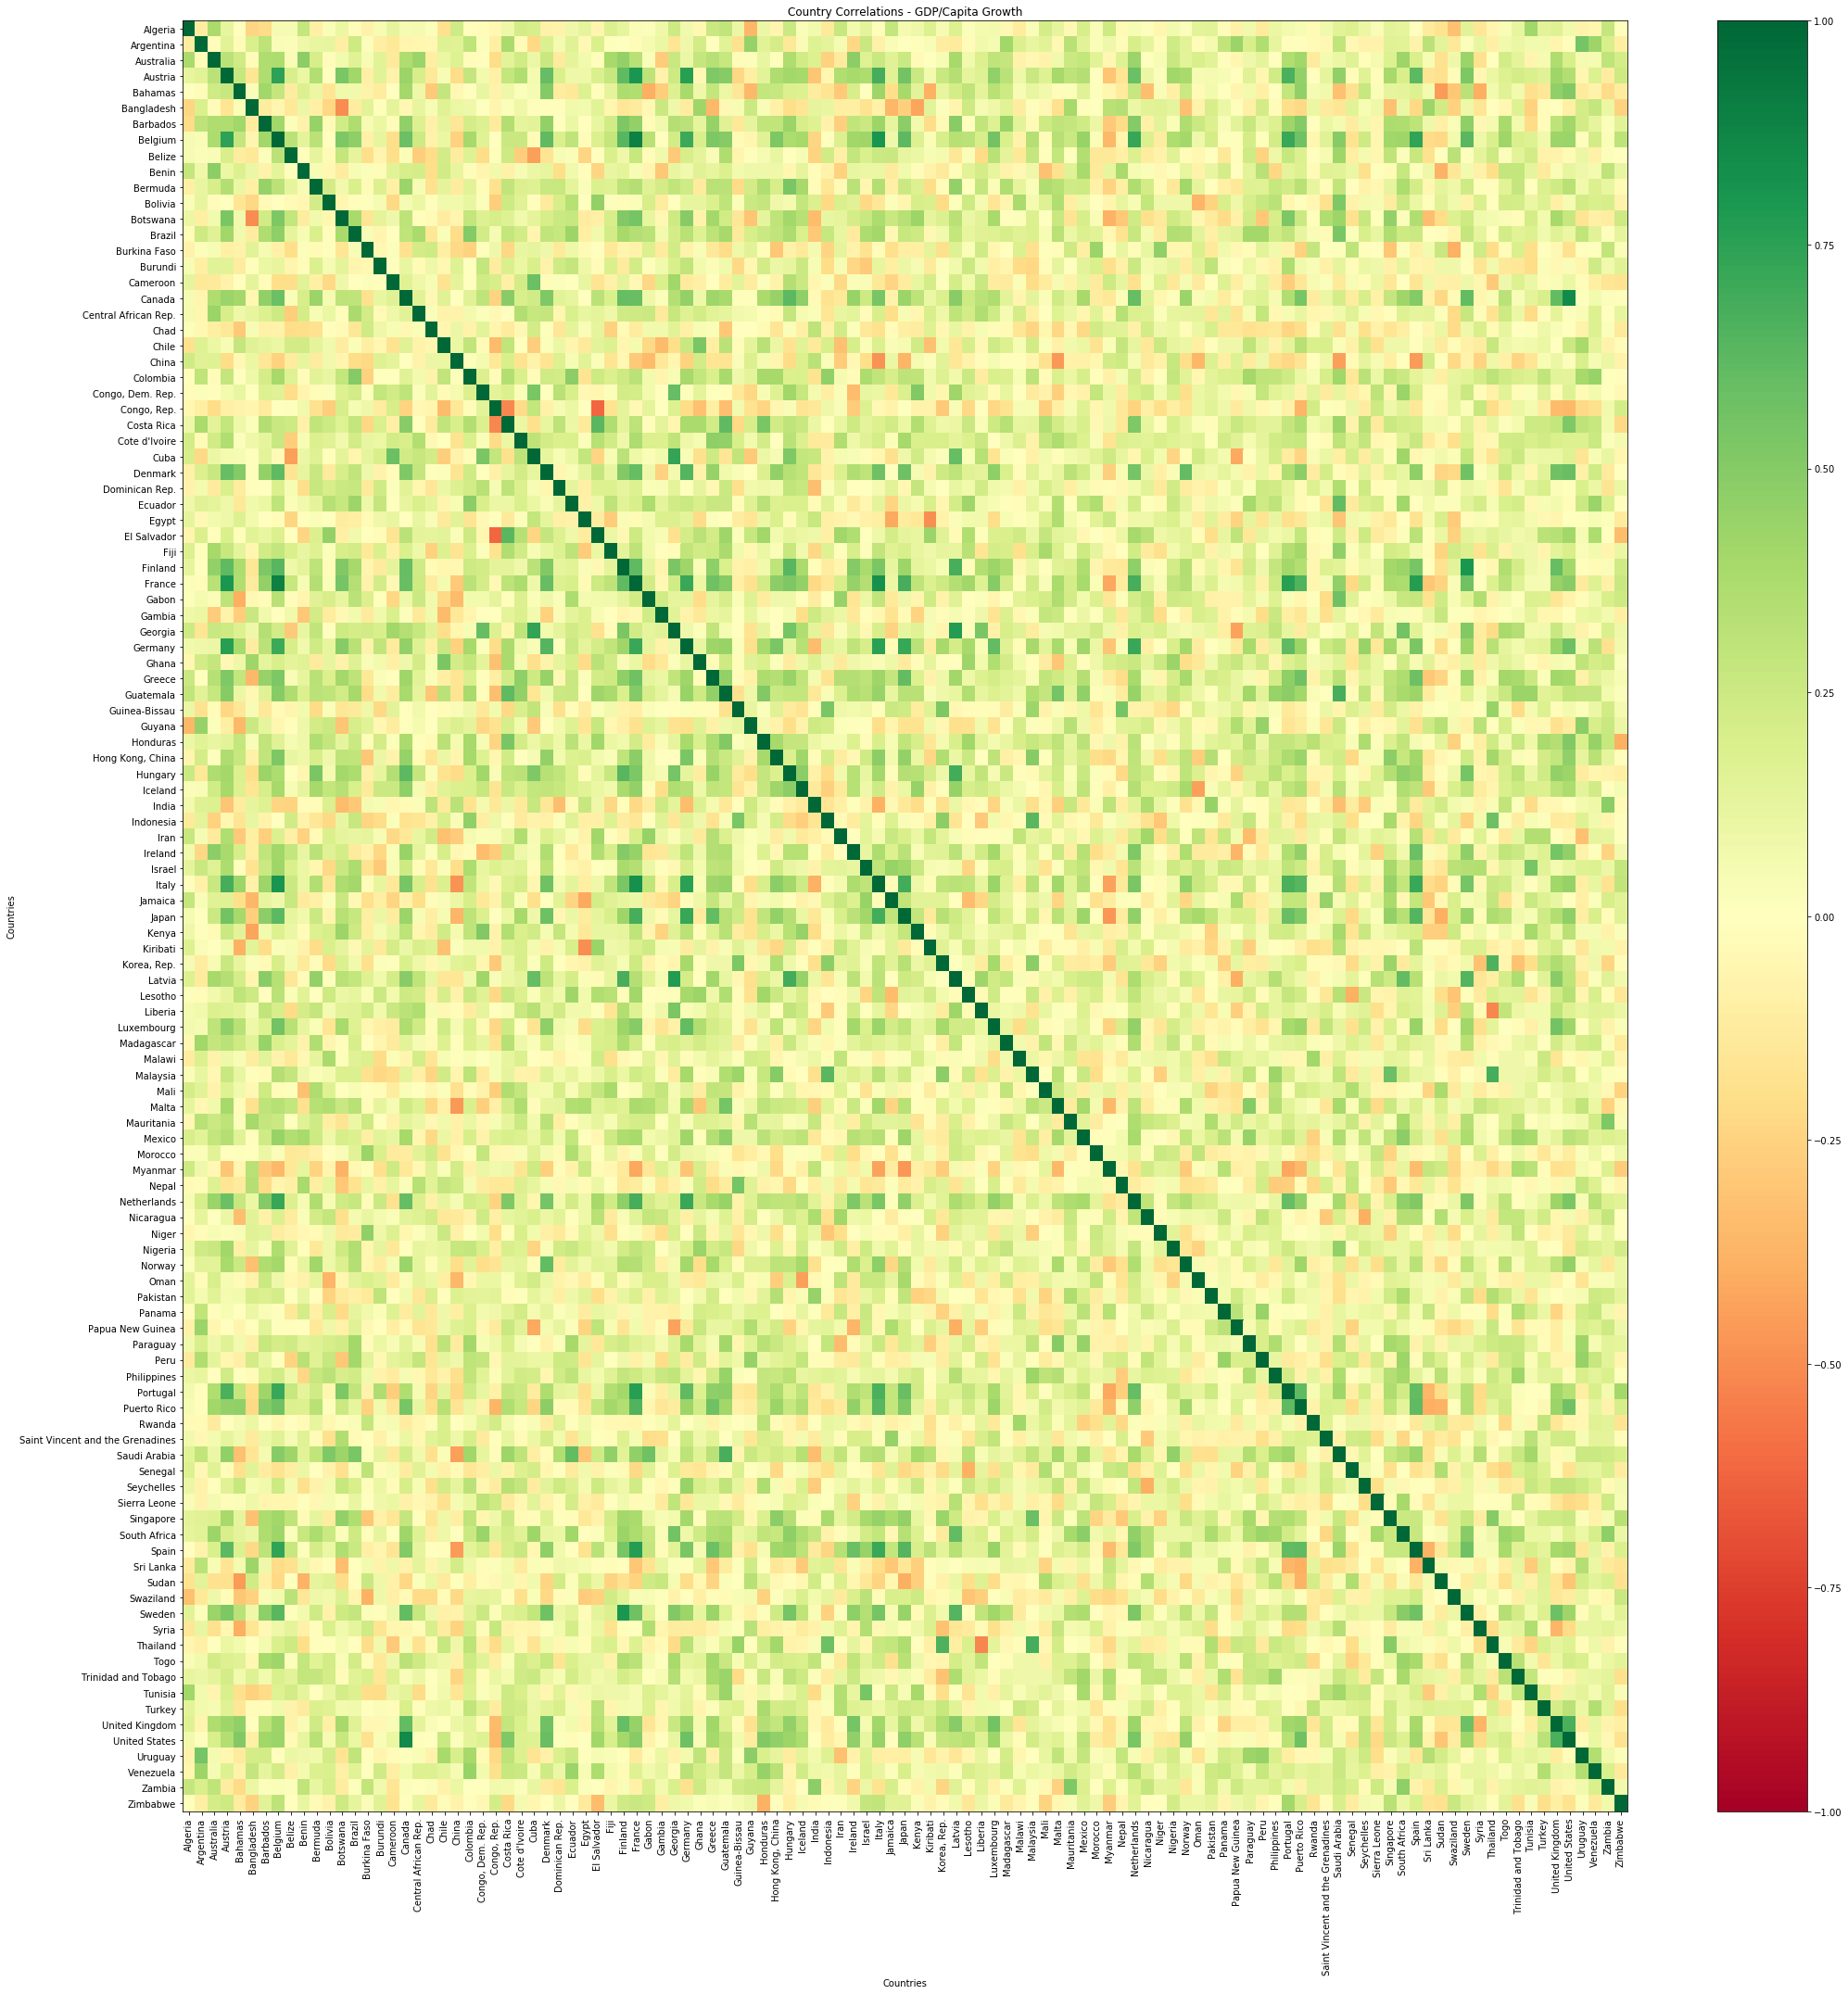

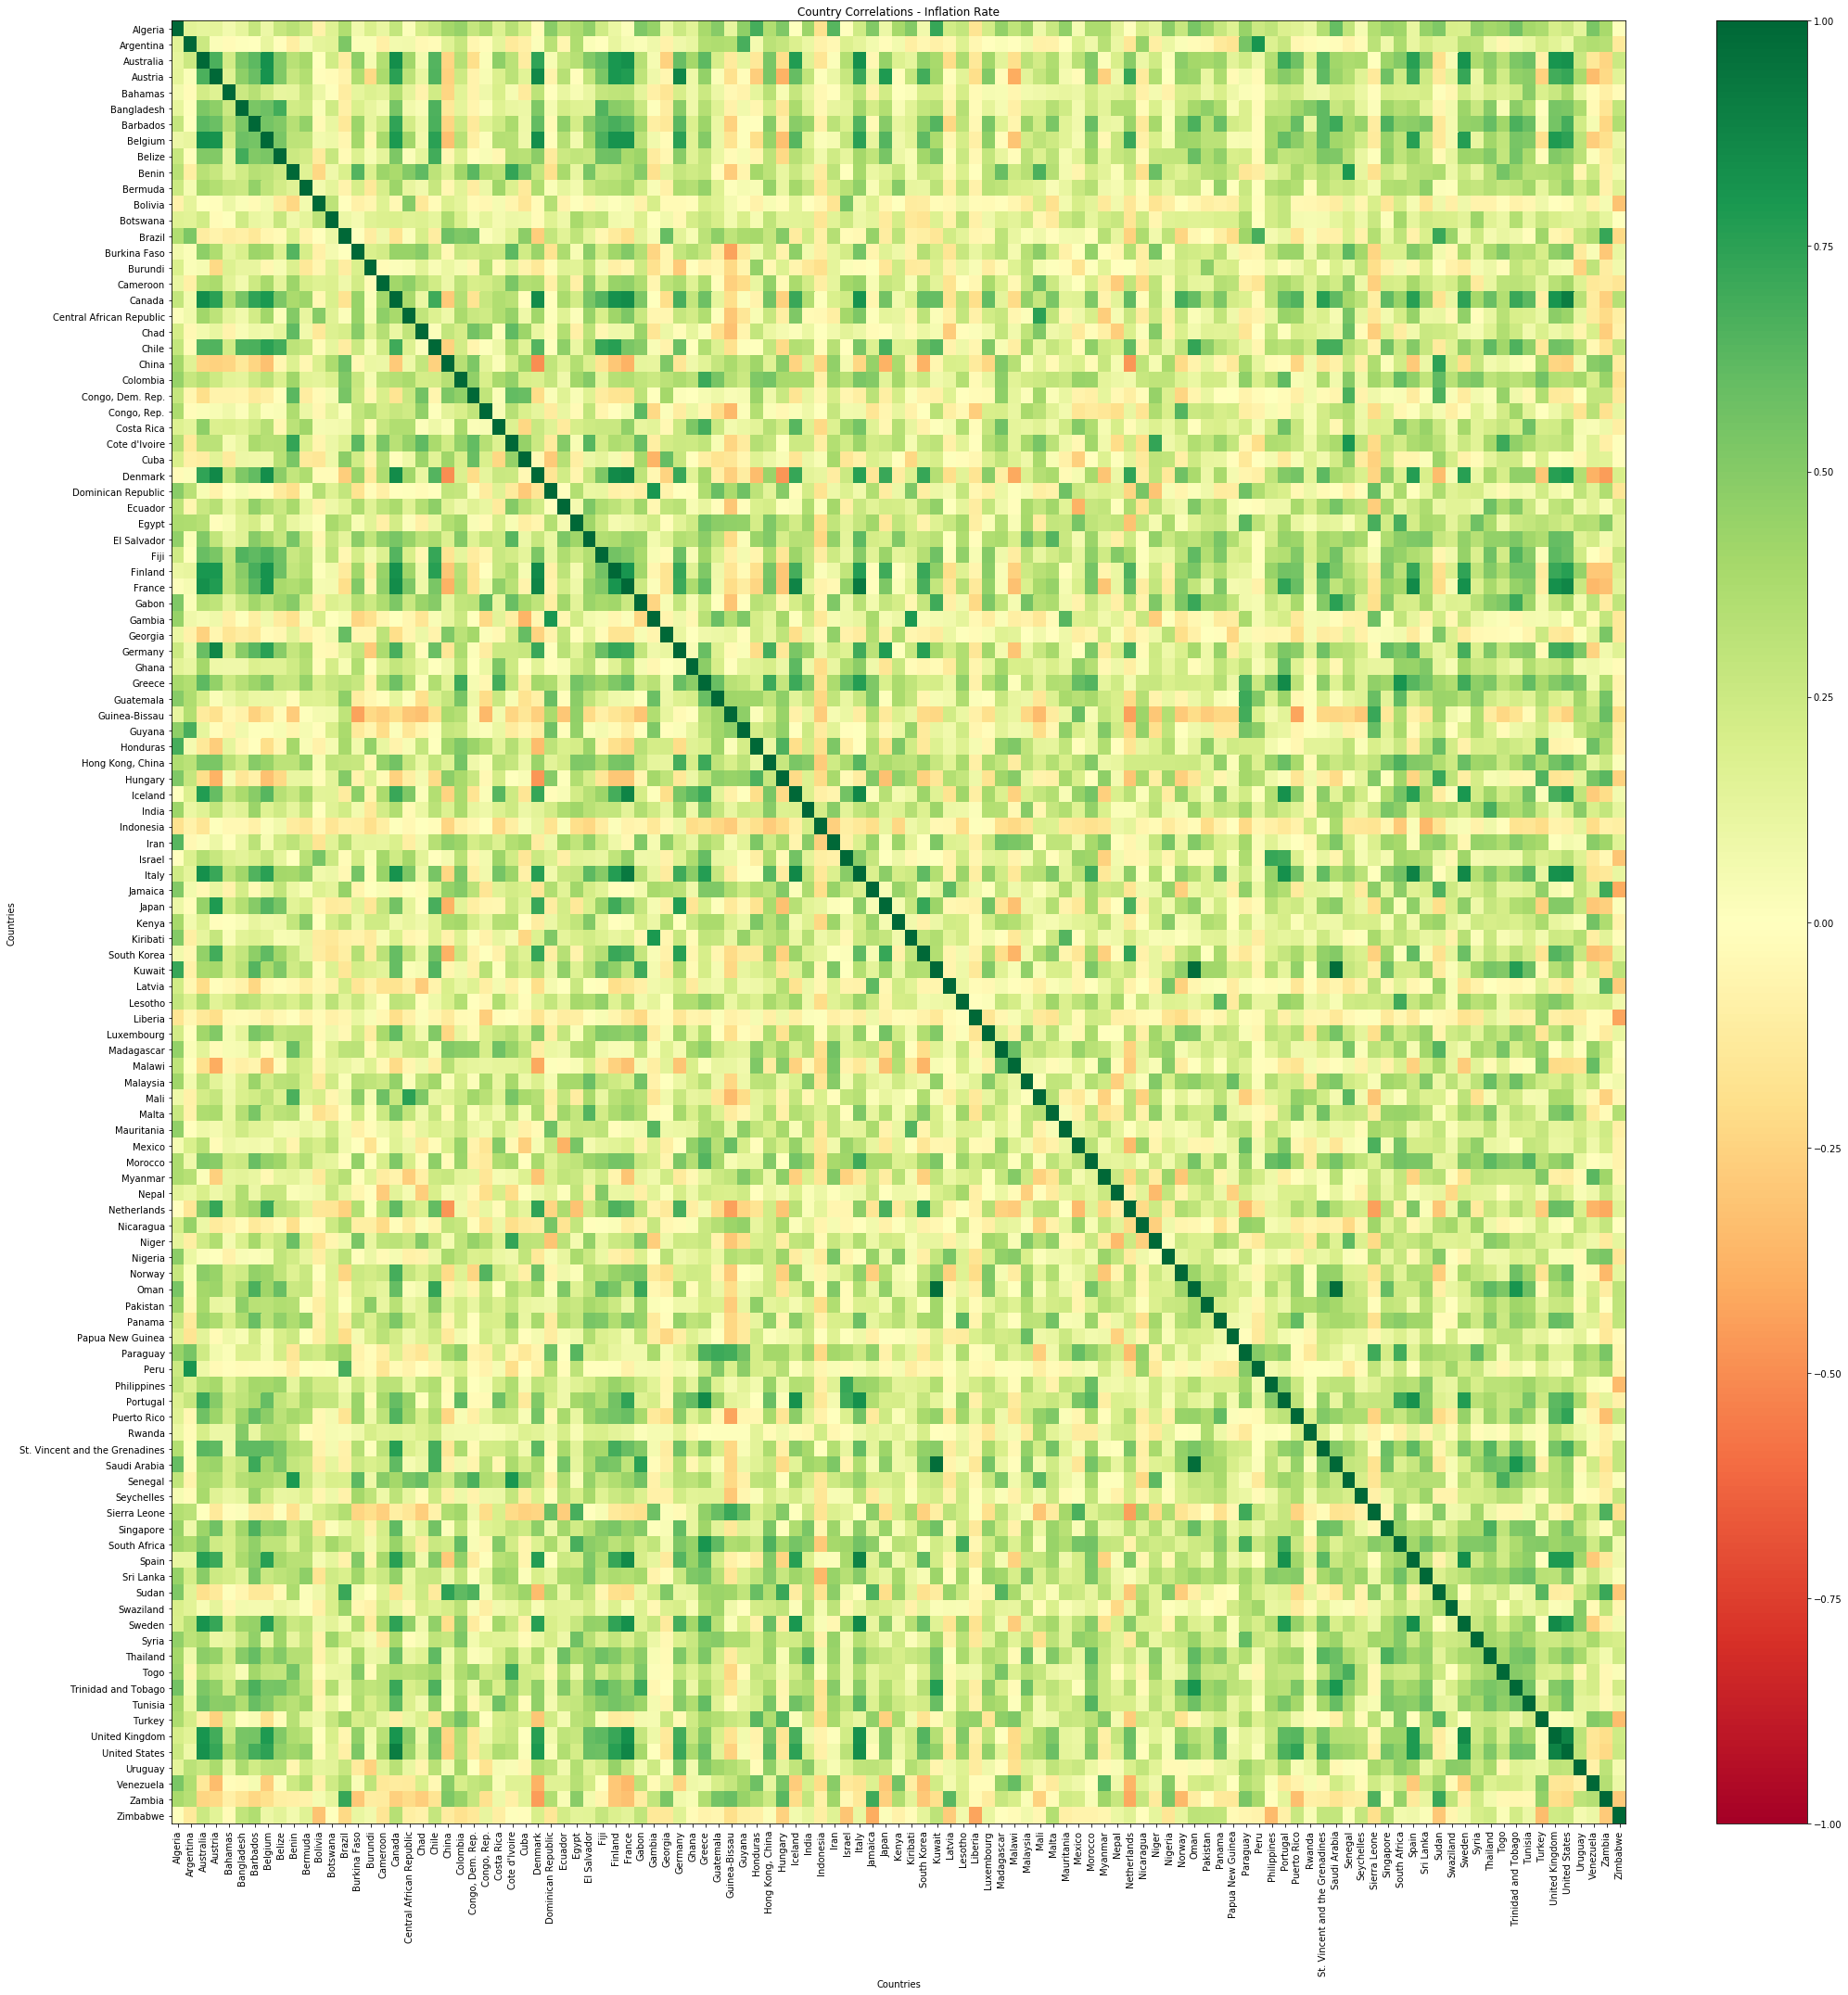

In [ ]:
country_heatmaps()

Ignoring the perfect '1.0' correlation each country shares with itself, the heatmaps are helpful for quickly visualizing the correlations across several hundred countries.

The GDP/Capita plot is slightly green, with many values white or yellow - suggesting that the wealth of most countries tends to grow together, though the relationships are generally weak. However, the Inflation plot is mostly green, including more patches of dark green, suggesting that Inflation trends are more commonly shared.

In contrast, the plot for Population Growth contains fewer neutral colors and is accented by streaks of dark green and red - suggesting much deeper divergence between countries.

Additional metadata around each country, such as its geography and membership in certain economic or political blocs, could enhance this analysis. However, such data points are outside of Udacity's approved datasets.

# Conclusions
Both hypotheses posed in this analysis were proven false:
 - Inflation has very weak correlations with GDP/Capita and Population growth; only Population Growth has a positive correlation
 - Population Growth and GDP/Capita are not positively correlated - they have a weak, negative correlation
Although GDP/Capita and Population Growth have exhibited stronger positive correlation in recent history, these relationships are still weak. Accordingly, there does not appear to be a causal relationship between either indicator and Inflation.

Likewise, there does not appear to be a causal relationship between Population Growth and GDP/Capita.

# Areas for Further Study
These analyses can be further enhanced with the inclusion of other data:
 - Additional indicators, such as money supply and labor force participation, may have stronger correlations with Inflation
 - Countries may have stronger correlations with countries they are closely related to, in terms of both geography, trade, political system, and economic focus (eg. services, manufacturing, commodity extraction, etc)
 - Correlations may be stronger if countries are bucketed for similarity in GDP/Capita or Population Growth (ie. comparing baskets of high-growth and low-growth countries)

# Lessons Learned

The process of conducting this analysis has identified considerations for future projects:
 - Source raw data whenever possible; true global rates for each indicator could have been determined if the raw totals were selected for analysis. Although the comparison of rates was convenient at the project's outset, each country's annual Inflation, GDP/Capita and Population Growth rates have important context in the underlying raw totals.
 - Scopes should be well-defined and strictly adhered to. Analyses involving economic variables are open to scope-creep and can be explored across numerous scales and timeframes.

# Supplementary Education
Additional information, beyond the Udacity course material, was used to complete this project. Gratitude and credit are owed to:
 - [Stack Overflow](https://stackoverflow.com/)
 - [Sentdex](https://www.youtube.com/user/sentdex)